# Homework assignment 9 (Lightweight Eastern edition)

This homework assignment considers only the disease spreading models and their numerical solutions 
already discussed in the interactive lecture from Wednesday 

**Deadline: Monday, 15th of April, 12:00.**

In [1]:
import numpy as np
from numpy import pi
from numpy.linalg import solve, norm    
import matplotlib.pyplot as plt


plt.xkcd()
newparams = {'figure.figsize': (6.0, 6.0),
             'axes.grid': True,
             'lines.markersize': 8, 
             'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

## Problem 1 SIHR model

**a)** Write down the final ODE system for the SIHR model developed during the first breakout session.
   Denote the rates for the transition $I \overset{\gamma_h}{\to} H$, $I \overset{\gamma_r}{\to} R$,
   and $H \overset{\delta}{\to} R$
   by $\gamma_h$ and $\gamma_r$, $\delta$, respectively. 
   
**b)** As the SIHR model is a refinement of the SIR model where we
   want to distinguish between infectious and hospitialized individuals, we assume the same total $\gamma$
   as for the simpler SIR model; that is,
   $$
   \gamma_r + \gamma_h =: \gamma = 1/18
   $$
   Assume that
   *  that 3.5% of all infected individuals will be hospitalized which means that $\gamma_h = 0.035\gamma$
   *  hospitalized individuals stay 14 days in the hospital on average, that is $\delta = 1/14$
   *  St. Olav's hospital has roughly 1000 beds with roughly 80% of them being occupied
   
   Use the same initial condition as in the Trondheim scenario as in the lecture, choose a tolerance $\mathrm{tol}$ such    that your numerical solutions are not off by more than 10 persons.
   Now compute and plot the solution $S, I, H, R$ using both the adaptive Euler-Heun and Fehlberg's method.
   Record and state the number of steps you needed with Euler-Heun vs Fehlberg.
   What is (approximately) the largest basic reproduction number $R_0$ for which we will not exceed the maximal number of    
   available beds?
  
  *Hint* Before you start, it might be helpful to review the [[SimpleCovidModel.ipynb notebook]](https://wiki.math.ntnu.no/lib/exe/fetch.php?tok=0f251d&media=https%3A%2F%2Fwww.math.ntnu.no%2Femner%2FTMA4125%2F2021v%2Flectures%2FSimpleCovidModel.ipynb). Some of the code snippets provided below might be helpful as well.

a)


\begin{align}
S' &= - \beta S I
\\
I' &= \beta S I - \gamma_h I - \gamma_r I
\\
H' &= \gamma_h I - \delta H
\\
R' &= \gamma_r I + \delta H,
\end{align}


In [2]:
# define SIHR class similar to SIR before
class SIHR:
    # Create model with given parameters
    def __init__(self, beta, gamma_r, gamma_h, delta):
        self.beta = beta # infectional rate
        self.gamma_r = gamma_r # removal rate
        self.gamma_h = gamma_h # removal rate
        self.delta = delta
    
    def __call__(self, t, y):
        # TODO: Implement rhs of SIHR model
        return np.array([-self.beta*y[0]*y[1],
                  self.beta*y[0]*y[1] - self.gamma_h*y[1] - self.gamma_r*y[1],
                  self.gamma_h*y[1] - self.delta*y[2],
                  self.gamma_r*y[1] + self.delta*y[2]])

In [3]:
from rkm import EmbeddedExplicitRungeKutta

#Heun-Euler metode
a    = np.array([[0,   0],
                 [1, 0]])
bhat = np.array([1/2, 1/2])
b    = np.array([1, 0])
c = np.array([0, 1])
order = 1

euler_heun = EmbeddedExplicitRungeKutta(a, b, c, bhat, order)

#Fehlberg method combines a 4th and 5th order method
a = np.array([[        0,          0,          0,         0,      0,  0],
              [      1/4,          0,          0,         0,      0,  0],
              [     3/32,       9/32,          0,         0,      0,  0],
              [1932/2197, -7200/2197,  7296/2197,         0,      0,  0],
              [  439/216,         -8,   3680/513, -845/4104,      0,  0],
              [    -8/27,          2, -3544/2565, 1859/4104, -11/40,  0]])

b =    np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])
bhat = np.array([25/216, 0,  1408/2565,   2197/4104,  -1/5,    0])
c = np.array([     0,
                 1/4,
                 3/8,
               12/13,
                   1,
                 1/2])
order = 4
fehlberg = EmbeddedExplicitRungeKutta(a, b, c, bhat, order)

# max number of steps
Nmax = 10000
tol = 10/200000 #Fraksjonsavvik; 10 personer av 200000 innbyggere

In [4]:
#Verdier for SIHR-modellen
r0 = 1.342 #Ved testing; for å ikke gå over 200 innlagte pga covid, 
          #på grunn av avvik mellom de metodene kan den være noe høyere også
gamma = 1/18
gamma_h = 0.035*gamma
gamma_r = gamma - gamma_h
beta = r0*gamma
delta = 1/14

# Lager modellen
sihr = SIHR(beta = beta, gamma_r = gamma_r, gamma_h = gamma_h, delta = delta)

In [5]:
#Samme startbetingelser som i fra SimpleCovidModel
I_0 = 1/200000
R_0 = 0
H_0 = 0 #Antar her at de okkuperte sengene på sykehuset ved start er andre årsaker en COVID
        #og at det antallet er konsant gjennom pandemien. Da er det 200 ledige senger for COVID-smittede.
S_0 = 1 - I_0

y0 = np.array([S_0, 
               I_0,
               H_0,
               R_0])
t0, T = 0, 750


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


Step is rejected at t = 58.575 with err = 7.360998590063493e-05
Step is rejected at t = 108.03073921398018 with err = 7.702436688900656e-05
Step is rejected at t = 139.90742781364702 with err = 5.671061181395657e-05
Finishing time-stepping reaching t = 750.0 with final time T = 750
Used 211 steps out of 10000 with 3 being rejected
Maks antall innlagte på sykehus på grunn av Corona er : 191


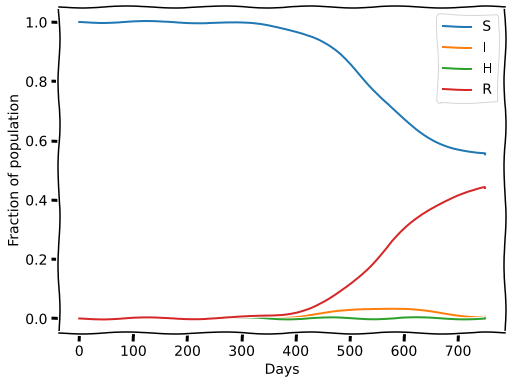

In [6]:
#Kjører metodene og plotter svarene:
#Euler-Heun
ts, ys = euler_heun(y0, t0, T, sihr, Nmax, tol=tol)
plt.close()
newparams['figure.figsize'] = (8,6)
plt.rcParams.update(newparams)
plt.plot(ts, ys, "-")
plt.legend(["S", "I", "H", "R"])
plt.xlabel("Days")
plt.ylabel("Fraction of population")


#Finner sjukehusinnleggelser pga Corona:
Innlagte = []
for sir in ys:
    Innlagte.append(sir[2])
    
print(f"Maks antall innlagte på sykehus på grunn av Corona er : {round(max(Innlagte)*200000)}")

Step is rejected at t = 58.575 with err = 6.560930837891416e-05
Step is rejected at t = 162.7906858806382 with err = 0.0022878275955145275
Finishing time-stepping reaching t = 750.0 with final time T = 750
Used 22 steps out of 10000 with 2 being rejected
Maks antall innlagte på sykehus på grunn av Corona er : 198


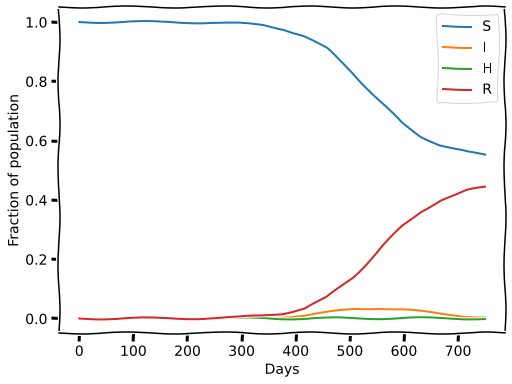

In [7]:
#Kjører metodene og plotter svarene:

ts, ys = fehlberg(y0, t0, T, sihr, Nmax, tol)
plt.close()
newparams['figure.figsize'] = (8,6)
plt.rcParams.update(newparams)
plt.plot(ts, ys, "-")
plt.legend(["S", "I", "H", "R"])
plt.xlabel("Days")
plt.ylabel("Fraction of population")

#Finner sjukehusinnleggelser pga Corona:
Innlagte = []
for sir in ys:
    Innlagte.append(sir[2])
    
print(f"Maks antall innlagte på sykehus på grunn av Corona er : {round(max(Innlagte)*200000)}")

* Euler-Heun metoden brukte 211 steg
* Fehlbergs metode brukte 22 steg
* Får at $R_0 \approx 1.342$, dersom sykehusene ikke skal bli overfylte

## Problem 2 SIHRt model

Redo problem 1, but this time develop and use an extension the SIHR model to account for time-limited immunity, assuming 1 year of immunity for each recovered person. Consider a time-period of 5 years and
find out how many "infection waves" will occur where the maximum capacity of beds are exceeded. 

Får et relativt likt system som i oppgave 1, men må legge til at det tilbakeføres immune til friske. Bruker $\epsilon$ som raten for at immuniteten går ut. Med sammme tankegang som for sykehuset i oppgave 1, er da $\epsilon = 1/365$. Vi får da likningssystemet:


\begin{align}
S' &= - \beta S I + \epsilon R
\\
I' &= \beta S I - \gamma_h I - \gamma_r I
\\
H' &= \gamma_h I - \delta H
\\
R' &= \gamma_r I + \delta H - \epsilon R,
\end{align}


In [8]:
# Lager SIHRt-klasse
class SIHRt:
    # Create model with given parameters
    def __init__(self, beta, gamma_r, gamma_h, delta, epsilon):
        self.beta = beta # infectional rate
        self.gamma_r = gamma_r # removal rate
        self.gamma_h = gamma_h # removal rate
        self.delta = delta
        self.epsilon = epsilon
    
    def __call__(self, t, y):
        return np.array([-self.beta*y[0]*y[1] + self.epsilon*y[3],
                  self.beta*y[0]*y[1] - self.gamma_h*y[1] - self.gamma_r*y[1],
                  self.gamma_h*y[1] - self.delta*y[2],
                  self.gamma_r*y[1] + self.delta*y[2] - self.epsilon*y[3]])

In [9]:
#Legger inn konstantene

r0 = 2
gamma = 1/18
gamma_h = 0.035*gamma
gamma_r = gamma - gamma_h
beta = r0*gamma
delta = 1/14
epsilon = 1/365

Nmax = 10000
tol = 10/200000 #Fraksjon; 10 personer av 200000 innbyggere

#Samme startbetingelser som i fra SimpleCovidModel
I_0 = 1/200000
R_0 = 0
H_0 = 0 #Antar her at de okkuperte sengene på sykehuset ved start er andre årsaker en COVID
        #og at det antallet er konsant gjennom pandemien. Da er det 200 ledige senger for COVID-smittede.
    
S_0 = 1 - I_0

y0 = np.array([S_0, 
               I_0,
               H_0,
               R_0])

t0, T = 0, (365*5) #5 år


Step is rejected at t = 28.47 with err = 9.811729626104958e-05
Step is rejected at t = 48.82137344383261 with err = 8.856946803260476e-05
Step is rejected at t = 61.05397483975463 with err = 6.109266190224957e-05
Step is rejected at t = 69.90691940565716 with err = 5.1564625481079755e-05
Finishing time-stepping reaching t = 1825.0 with final time T = 1825
Used 706 steps out of 10000 with 4 being rejected


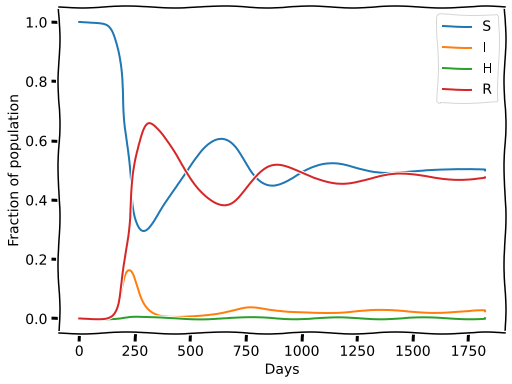

In [10]:
sihrt = SIHRt(beta = beta, gamma_r = gamma_r, gamma_h = gamma_h, delta = delta, epsilon = epsilon)

#Med Euler-Heun

ts, ys = euler_heun(y0, t0, T, sihrt, Nmax, tol=tol)

plt.close()
newparams['figure.figsize'] = (8,6)
plt.rcParams.update(newparams)
plt.plot(ts, ys, "-")
plt.legend(["S", "I", "H", "R"])
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

Maks antall innlagte på sykehus på grunn av Corona er : 810


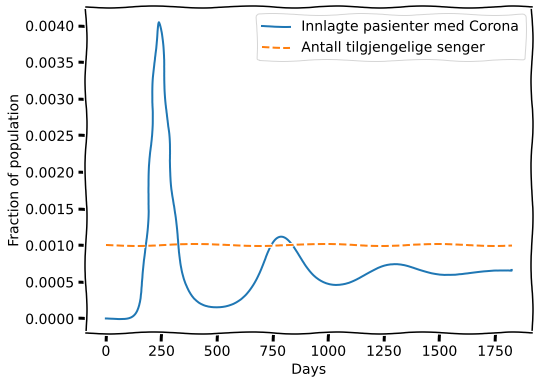

In [11]:
H = []
for SIHR in ys:
    H.append(SIHR[2])   
    
print(f"Maks antall innlagte på sykehus på grunn av Corona er : {round(max(H)*200000)}")


x = np.linspace(0, 5*365, 100)
y = 0*x + 200/200000

plt.close()
newparams['figure.figsize'] = (8,6)
plt.rcParams.update(newparams)
plt.plot(ts, H)
plt.plot(x, y, '--')
plt.legend(["Innlagte pasienter med Corona", "Antall tilgjengelige senger"])
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

Step is rejected at t = 28.47 with err = 6.864940620636603e-05
Step is rejected at t = 86.90599360302808 with err = 0.0005929149935678104
Step is rejected at t = 122.0529257544298 with err = 0.00010613534763288317
Step is rejected at t = 209.64466135167322 with err = 0.00021710812755961707
Step is rejected at t = 494.78731349424845 with err = 9.377350274870878e-05
Step is rejected at t = 548.3298720102617 with err = 6.755186104993603e-05
Step is rejected at t = 1661.4239201362643 with err = 5.584308451594294e-05
Finishing time-stepping reaching t = 1825.0 with final time T = 1825
Used 58 steps out of 10000 with 7 being rejected


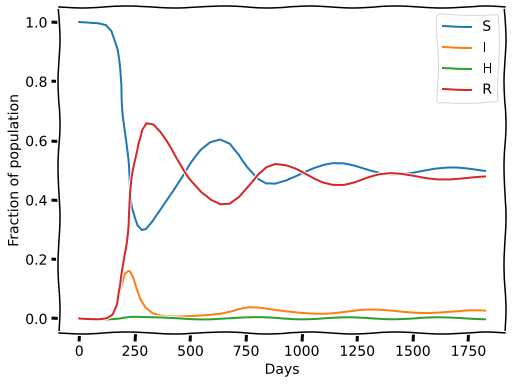

In [12]:
#Med Fehlberg

ts, ys = fehlberg(y0, t0, T, sihrt, Nmax, tol=tol)

plt.close()
newparams['figure.figsize'] = (8,6)
plt.rcParams.update(newparams)
plt.plot(ts, ys, "-")
plt.legend(["S", "I", "H", "R"])
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

Maks antall innlagte på sykehus på grunn av Corona er : 798


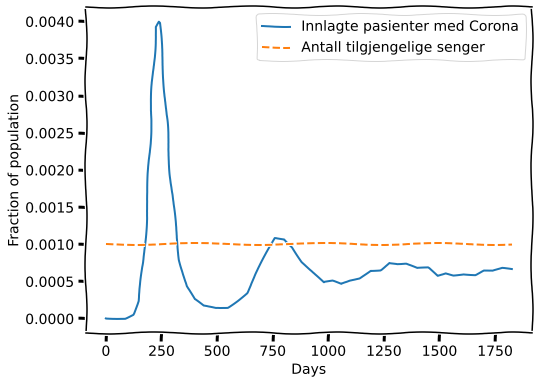

In [13]:
H = []
for SIHR in ys:
    H.append(SIHR[2])   
    
print(f"Maks antall innlagte på sykehus på grunn av Corona er : {round(max(H)*200000)}")


x = np.linspace(0, 5*365, 100)
y = 0*x + 200/200000

plt.close()
newparams['figure.figsize'] = (8,6)
plt.rcParams.update(newparams)
plt.plot(ts, H)
plt.plot(x, y, '--')
plt.legend(["Innlagte pasienter med Corona", "Antall tilgjengelige senger"])
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

* Det blir to smittebølger hvor det er flere innlagte enn antallet senger med $R_0=2$ 
* Euler-Heuns metode brukte 706 steg
* Fehlbergs metode brukte 58 steg